In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
sns.set_theme(style="whitegrid")


In [3]:
def process_crop(file_path):
    # Load dataset
    data = pd.read_csv(file_path)
    crop_name = file_path.split('/')[-1].split('_')[0]  # Extract crop name from file name

    # One-hot encode DISTRICT_NAME
    data = pd.get_dummies(data, columns=['DISTRICT_NAME'], prefix='DISTRICT', drop_first=True)

    # Prepare features (X) and target (y)
    X = data.drop(columns=['YEAR', 'CROP_TYPE', 'PRODUCTION'])
    y = data['PRODUCTION']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features for SVR
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    svr_model = SVR(kernel='linear', C=10, epsilon=0.5)

    lr_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    svr_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_lr = lr_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_test)
    y_pred_svr = svr_model.predict(X_test_scaled)

    # Evaluate models
    results = {
        "Crop": crop_name,
        "Model": ["Linear Regression", "Random Forest", "SVR"],
        "MAE": [
            mean_absolute_error(y_test, y_pred_lr),
            mean_absolute_error(y_test, y_pred_rf),
            mean_absolute_error(y_test, y_pred_svr),
        ],
        "RMSE": [
            np.sqrt(mean_squared_error(y_test, y_pred_lr)),
            np.sqrt(mean_squared_error(y_test, y_pred_rf)),
            np.sqrt(mean_squared_error(y_test, y_pred_svr)),
        ],
        "R²": [
            r2_score(y_test, y_pred_lr),
            r2_score(y_test, y_pred_rf),
            r2_score(y_test, y_pred_svr),
        ],
    }

    # Feature importance for Random Forest
    feature_importances = rf_model.feature_importances_
    importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": feature_importances}
    ).sort_values(by="Importance", ascending=False).head(10)

    return results, y_test, y_pred_lr, y_pred_rf, y_pred_svr, importance_df


Top 10 Features for BARLEY - Random Forest


,Feature,Importance
0,AREA,0.826990
14,SPRING_WIND_SPEED,0.031424
16,WINTER_WIND_SPEED,0.016189
1,AUTUMN_HUMIDITY,0.013080
4,WINTER_HUMIDITY,0.012715
15,SUMMER_WIND_SPEED,0.011704
2,SPRING_HUMIDITY,0.010533
13,AUTUMN_WIND_SPEED,0.008881
8,WINTER_RAINFALL,0.008415
6,SPRING_RAINFALL,0.008301


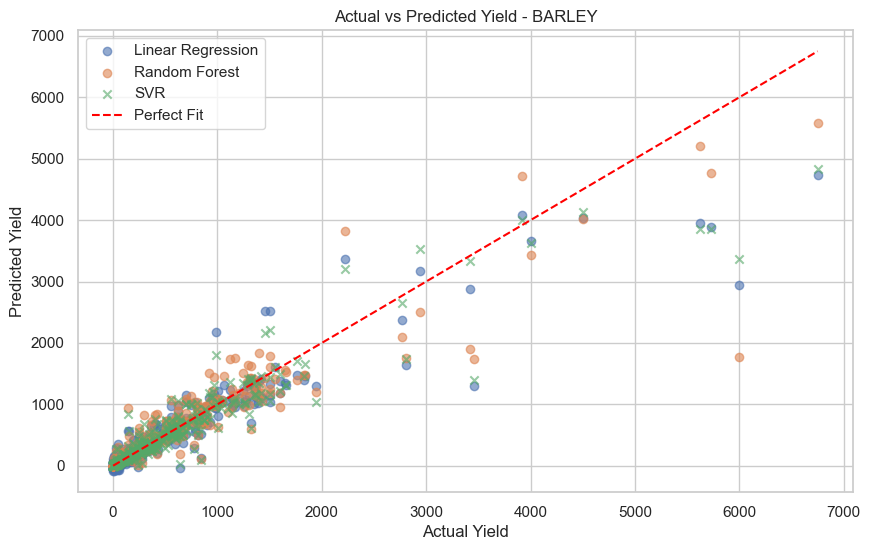

Top 10 Features for MAIZE - Random Forest


,Feature,Importance
0,AREA,0.846781
3,SUMMER_HUMIDITY,0.033561
2,SPRING_HUMIDITY,0.020653
7,SUMMER_RAINFALL,0.011000
13,AUTUMN_WIND_SPEED,0.009233
6,SPRING_RAINFALL,0.009050
4,WINTER_HUMIDITY,0.008072
14,SPRING_WIND_SPEED,0.007768
16,WINTER_WIND_SPEED,0.006990
5,AUTUMN_RAINFALL,0.005357


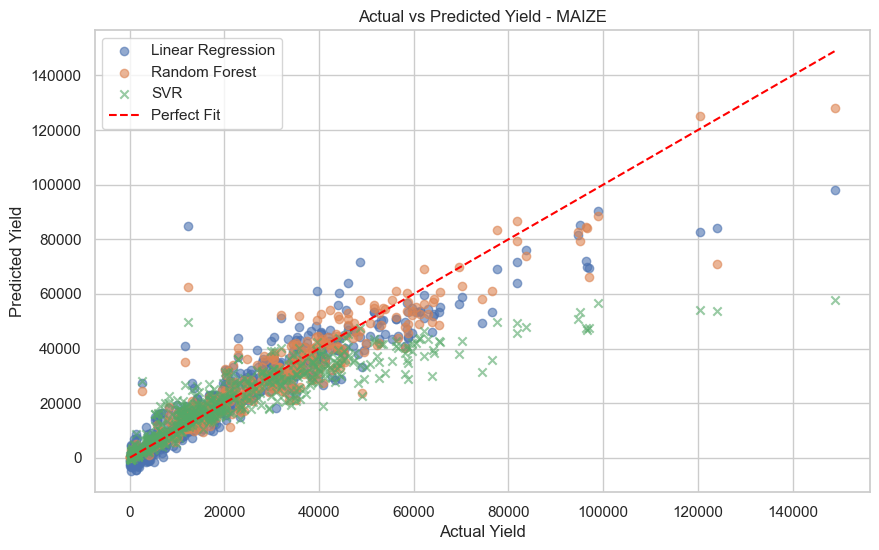

Top 10 Features for MILLET - Random Forest


,Feature,Importance
0,AREA,0.939126
39,DISTRICT_GULMI,0.007044
38,DISTRICT_GORKHA,0.004234
16,WINTER_WIND_SPEED,0.003312
7,SUMMER_RAINFALL,0.002954
3,SUMMER_HUMIDITY,0.002828
11,SUMMER_TEMPERATURE,0.002726
15,SUMMER_WIND_SPEED,0.002688
14,SPRING_WIND_SPEED,0.002663
4,WINTER_HUMIDITY,0.002536


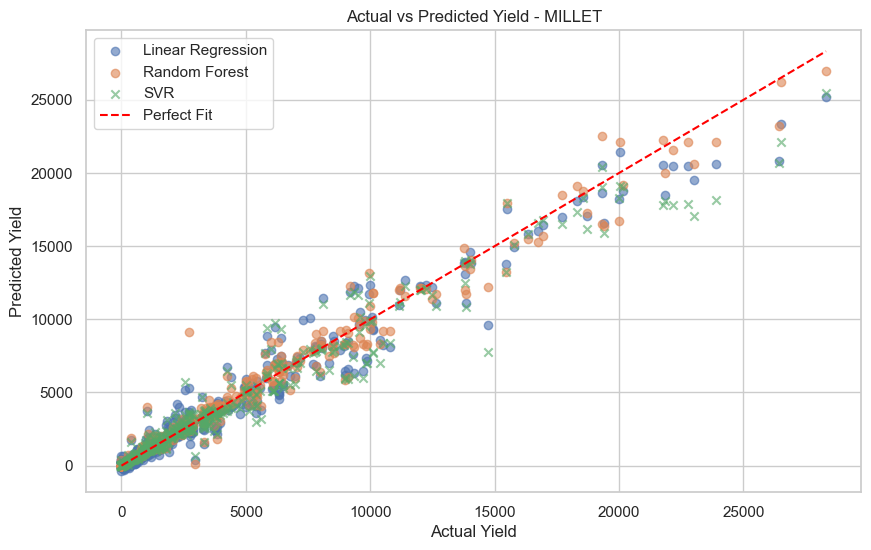

Top 10 Features for PADDY - Random Forest


,Feature,Importance
0,AREA,0.898162
7,SUMMER_RAINFALL,0.009507
4,WINTER_HUMIDITY,0.009329
15,SUMMER_WIND_SPEED,0.009294
3,SUMMER_HUMIDITY,0.007395
2,SPRING_HUMIDITY,0.007347
5,AUTUMN_RAINFALL,0.006915
8,WINTER_RAINFALL,0.006674
6,SPRING_RAINFALL,0.006482
1,AUTUMN_HUMIDITY,0.005470


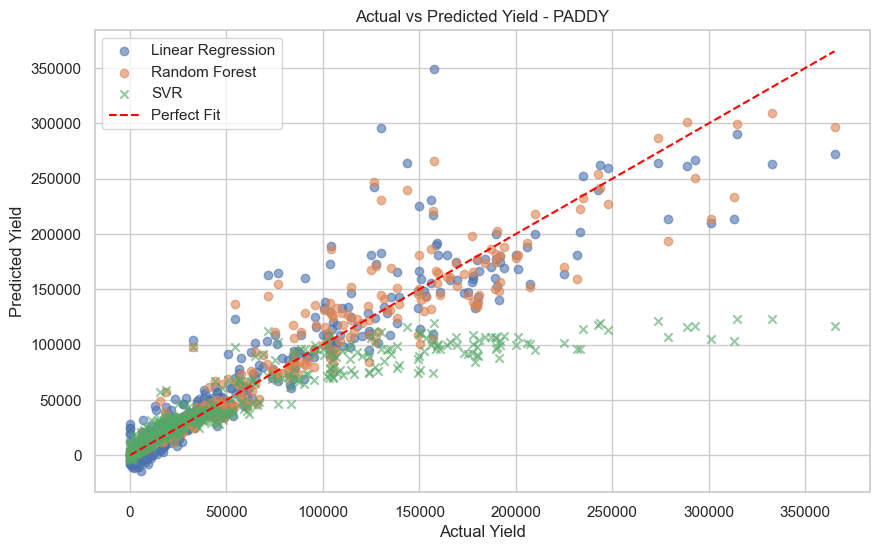

Top 10 Features for WHEAT - Random Forest


,Feature,Importance
0,AREA,0.841337
2,SPRING_HUMIDITY,0.022650
4,WINTER_HUMIDITY,0.018931
15,SUMMER_WIND_SPEED,0.013898
3,SUMMER_HUMIDITY,0.013178
5,AUTUMN_RAINFALL,0.011098
1,AUTUMN_HUMIDITY,0.010426
6,SPRING_RAINFALL,0.010054
7,SUMMER_RAINFALL,0.007076
13,AUTUMN_WIND_SPEED,0.006645


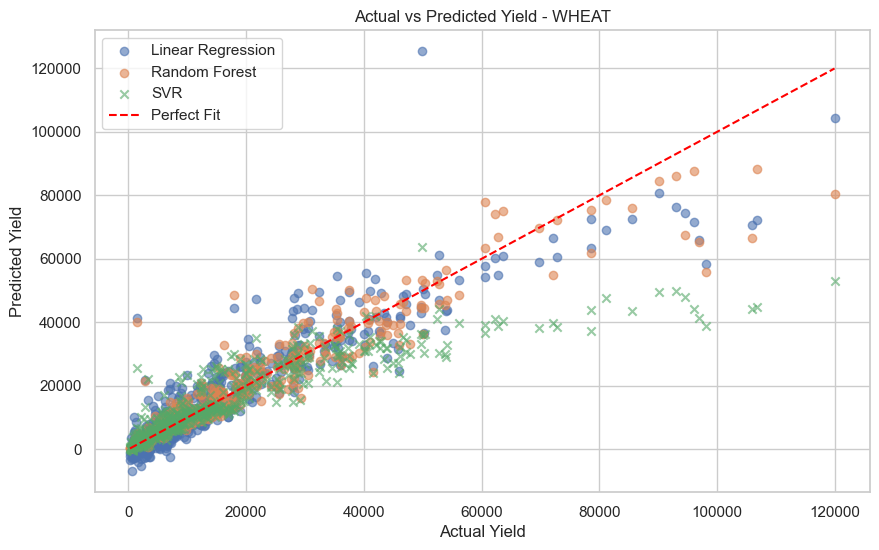

In [5]:
# List of file paths
file_paths = [
    "FinalDatasets/BARLEY_data_merged.csv",
    "FinalDatasets/MAIZE_data_merged.csv",
    "FinalDatasets/MILLET_data_merged.csv",
    "FinalDatasets/PADDY_data_merged.csv",
    "FinalDatasets/WHEAT_data_merged.csv",
]

# Initialize summary DataFrame
summary_df = pd.DataFrame()

# Loop through each crop
for file_path in file_paths:
    results, y_test, y_pred_lr, y_pred_rf, y_pred_svr, importance_df = process_crop(file_path)

    # Append results to summary DataFrame
    summary_df = pd.concat([summary_df, pd.DataFrame(results)], ignore_index=True)

    # Display crop-specific feature importance
    crop_name = results["Crop"]
    print(f"Top 10 Features for {crop_name} - Random Forest")
    display(importance_df)  # Jupyter-friendly display

    # Scatter plot: Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_lr, label="Linear Regression", alpha=0.6)
    plt.scatter(y_test, y_pred_rf, label="Random Forest", alpha=0.6)
    plt.scatter(y_test, y_pred_svr, label="SVR", alpha=0.6, marker="x")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red", label="Perfect Fit")
    plt.title(f"Actual vs Predicted Yield - {crop_name}")
    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.legend()
    plt.show()


In [6]:
# Summary of all results
summary_df = summary_df.round(2)
print("Model Performance Summary:")
display(summary_df)  # Jupyter-friendly display of the summary


Model Performance Summary:


,Crop,Model,MAE,RMSE,R²
0,BARLEY,Linear Regression,109.68,265.90,0.87
1,BARLEY,Random Forest,94.90,271.23,0.86
2,BARLEY,SVR,90.07,247.58,0.88
3,MAIZE,Linear Regression,4702.67,7608.24,0.86
4,MAIZE,Random Forest,3225.80,5948.51,0.92
5,MAIZE,SVR,6087.73,11197.97,0.70
6,MILLET,Linear Regression,527.98,917.32,0.96
7,MILLET,Random Forest,347.37,730.92,0.98
8,MILLET,SVR,482.45,1032.05,0.95
9,PADDY,Linear Regression,11660.68,22209.00,0.88
